In [ ]:
import pandas as pd
from matplotlib import pylab

params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22, 
 'figure.titlesize': 24
 }
pylab.rcParams.update(params)

In [ ]:
# Q1
df = pd.read_csv("./virus_data.csv")
df.shape

(1250, 26)

In [ ]:
# Q2
df['conversations_per_day'].value_counts()

1     232
2     213
3     191
4     158
5     127
0     117
6      69
7      46
8      34
9      21
10     20
12      7
11      5
13      4
15      3
14      2
16      1
Name: conversations_per_day, dtype: int64

In [ ]:
# Q4
from sklearn.model_selection import train_test_split
train_size = 0.8
test_size = 1 - train_size
train, test = train_test_split(df, test_size=test_size, train_size=train_size, random_state=51+14, shuffle=True)

In [ ]:
# Q5
spread = train['spread']
print("Correlation of 'spread','PCR_01' is: {:.3f}".format(spread.corr(train['PCR_01'])))
print("Correlation of 'spread','PCR_02' is: {:.3f}".format(spread.corr(train['PCR_02'])))
print("Correlation of 'spread','PCR_09' is: {:.3f}".format(spread.corr(train['PCR_09'])))

Correlation of 'spread','PCR_01' is: 0.113
Correlation of 'spread','PCR_02' is: -0.022
Correlation of 'spread','PCR_09' is: 0.513


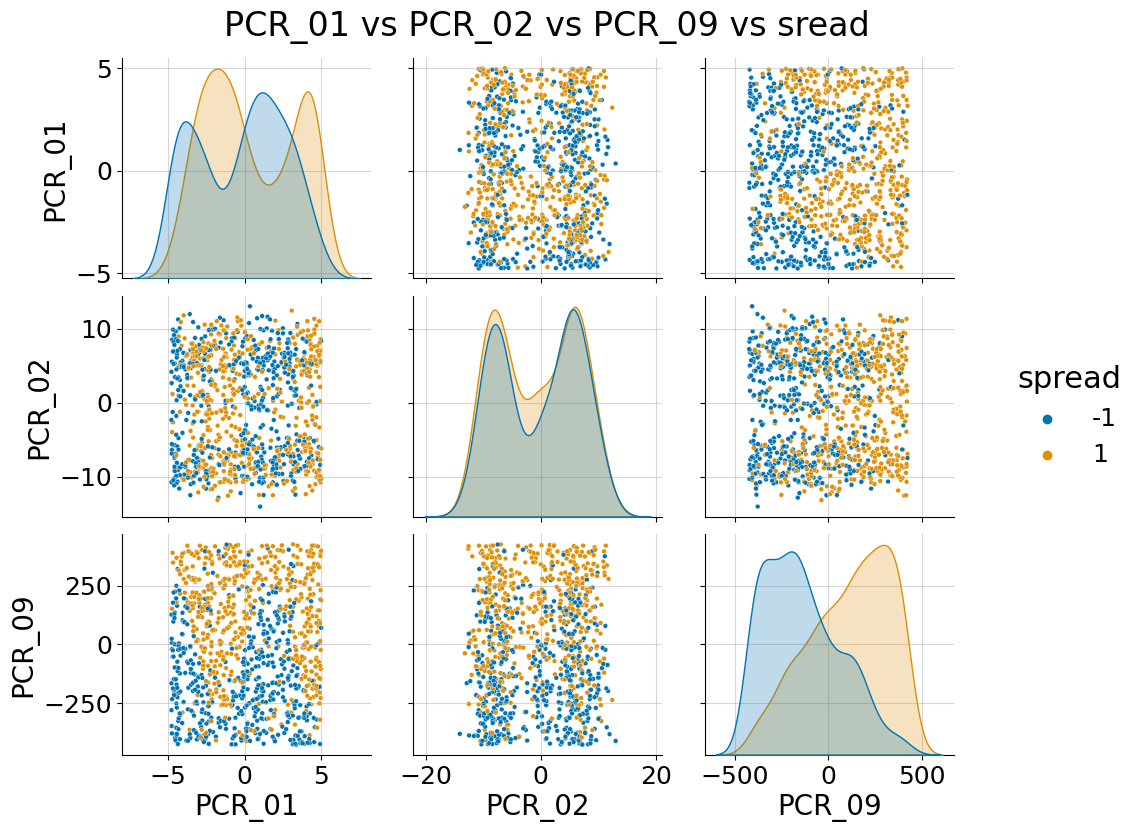

In [ ]:
# Q6
import seaborn as sns
import numpy as np

g = sns.pairplot(train[['PCR_01','PCR_02','PCR_09','spread']], hue='spread', plot_kws={'s': 12}, palette='colorblind')
g.fig.suptitle("PCR_01 vs PCR_02 vs PCR_09 vs sread", y=1.04)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)

  g.fig.set_size_inches(12,8)

In [ ]:
# Q7
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import cdist
import numpy as np


class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors: int = 3):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Fit the model to vectors in X, with their respected label in y
        # Params: X - dataset of feature vectors
        #         y - corresponding label for each vector in X
        # Returns: The fitted model

        self.X = np.copy(X)
        self.y = np.copy(y)
        return self

    def predict(self, X):
        # Predict the label of vectors in X using the fitted model
        # Params: X - unlabeled vectors
        # Returns: predictions vector for X (using the fitted model)
 
        predictions = None
        distances_matrix = cdist(X, self.X)
        closest_k_neighbours = np.argpartition(distances_matrix, self.n_neighbors, axis=1)[:, :self.n_neighbors]
        neighbors_tags = self.y[closest_k_neighbours]
        predictions = np.sign(np.sum(neighbors_tags, axis=1))
        return predictions

In [ ]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

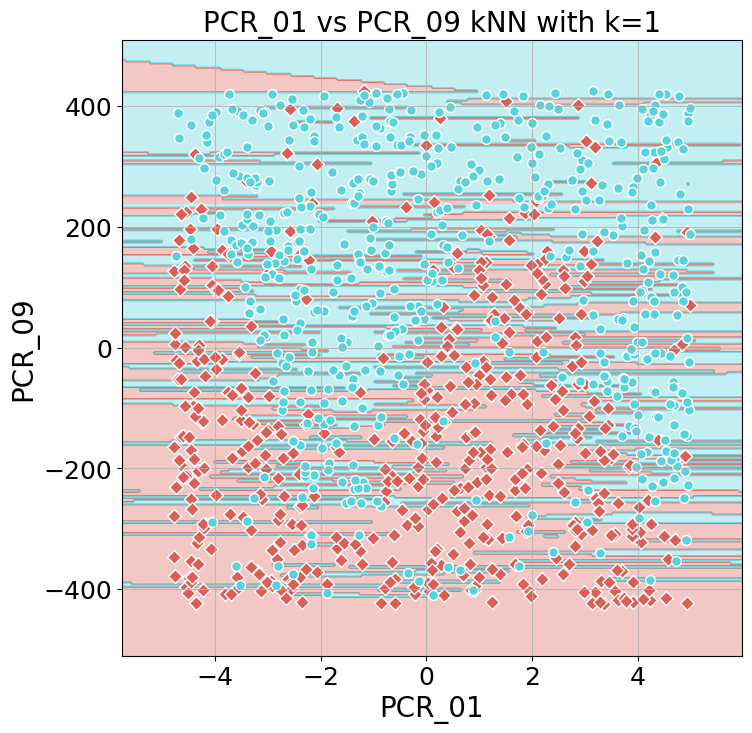

The model's accuracy for the train set is:  1.0
The model's accuracy for the test set is:  0.748


In [ ]:
# Q8

# Creating temporary DataFrame of the 2 fetures we chose in Q6
temp_train_X_df = train[['PCR_01','PCR_09']].copy()
temp_train_Y_df = train[['spread']].copy()
temp_test_X_df = test[['PCR_01','PCR_09']].copy()
temp_test_Y_df = test[['spread']].copy()

# Training a kNN model of this subset with k=1 
kNN_model=kNN(1)
kNN_model.fit(temp_train_X_df, temp_train_Y_df)
visualize_clf(kNN_model, temp_train_X_df, temp_train_Y_df, "PCR_01 vs PCR_09 kNN with k=1", "PCR_01", "PCR_09")

# Compute the training accuracy and test accuracy of the model
train_accuracy = kNN_model.score(temp_train_X_df, temp_train_Y_df)
test_accuracy = kNN_model.score(temp_test_X_df, temp_test_Y_df)

print("The model's accuracy for the train set is: ", train_accuracy)
print("The model's accuracy for the test set is: ", test_accuracy)

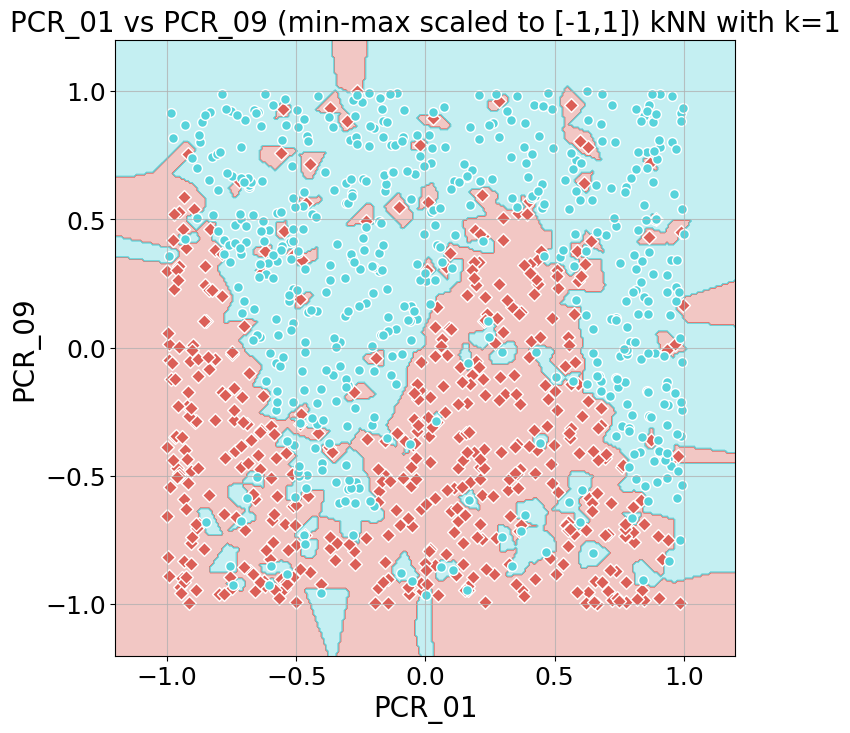

The model's accuracy for the train set is:  1.0
The model's accuracy for the test set is:  0.756


In [ ]:
# Q9
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

# Using the min-max scaler to normalize the chosen features from Q6 
train_minmax_scaled_X = scaler.fit_transform(temp_train_X_df)
test_minmax_scaled_X = scaler.fit_transform(temp_test_X_df)

# Training a kNN model of this normalized subset with k=1
kNN_model.fit(train_minmax_scaled_X, temp_train_Y_df)

visualize_clf(kNN_model, train_minmax_scaled_X, temp_train_Y_df, "PCR_01 vs PCR_09 (min-max scaled to [-1,1]) kNN with k=1", "PCR_01", "PCR_09")

# Compute the training accuracy and test accuracy of the normalized model
train_accuracy = kNN_model.score(train_minmax_scaled_X, temp_train_Y_df)
test_accuracy = kNN_model.score(test_minmax_scaled_X, temp_test_Y_df)

print("The model's accuracy for the train set is: ", train_accuracy)
print("The model's accuracy for the test set is: ", test_accuracy)

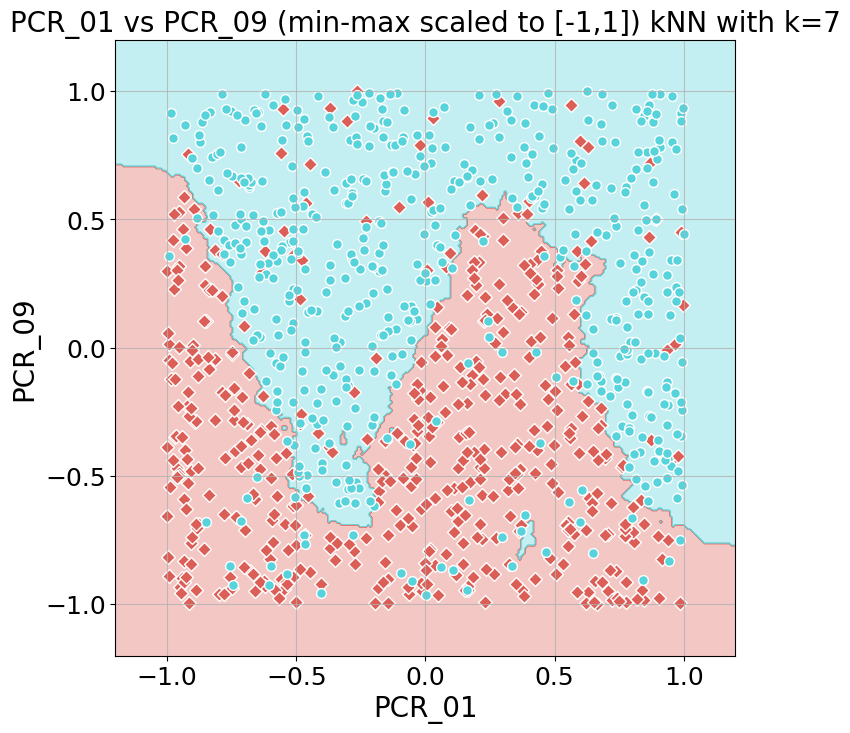

The model's accuracy for the train set is:  0.882
The model's accuracy for the test set is:  0.884


In [ ]:
# Q10

# Training a kNN model of this normalized subset with k=7
kNN_7_model = kNN(7)
kNN_7_model.fit(train_minmax_scaled_X, temp_train_Y_df)

visualize_clf(kNN_7_model, train_minmax_scaled_X, temp_train_Y_df, "PCR_01 vs PCR_09 (min-max scaled to [-1,1]) kNN with k=7", "PCR_01", "PCR_09")

# Compute the training accuracy and test accuracy of the normalized model
train_accuracy = kNN_7_model.score(train_minmax_scaled_X, temp_train_Y_df)
test_accuracy = kNN_7_model.score(test_minmax_scaled_X, temp_test_Y_df)

print("The model's accuracy for the train set is: ", train_accuracy)
print("The model's accuracy for the test set is: ", test_accuracy)

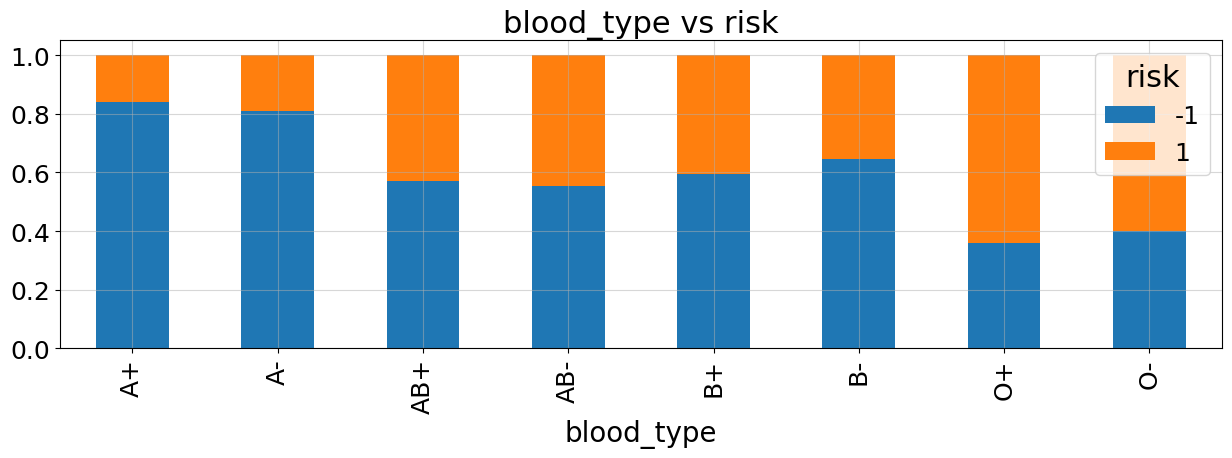

In [ ]:
# Q13
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=1, sharey=False, figsize=(15,4))
ax.set_title("blood_type vs risk")
_ = pd.crosstab(train['blood_type'], train['risk'], normalize="index").plot(kind='bar', stacked=True, ax=ax).grid(alpha=0.5)

In [ ]:
# Grouping blood types into 3 blood type groups
train.insert(len(train.columns)-2, "group_1_blood_type", train['blood_type'].isin(['A+','A-']))
train['group_1_blood_type'] = train['group_1_blood_type'].replace({True: 1, False: 0})
train.insert(len(train.columns)-2, "group_2_blood_type", train['blood_type'].isin(['AB+','AB-','B+','B-']))
train['group_2_blood_type'] = train['group_2_blood_type'].replace({True: 1, False: 0})
train.insert(len(train.columns)-2, "group_3_blood_type", train['blood_type'].isin(['O+','O-']))
train['group_3_blood_type'] = train['group_3_blood_type'].replace({True: 1, False: 0})

# Removing the blood_type feature
train = train.drop('blood_type', axis=1)

In [ ]:
# Q14

# symptoms OHE - Extracting infromation from the symptoms feature
train['symptoms'] = train['symptoms'].fillna("")

# Creating 5 Boolean features for each reported symptom (1 for subject has the symptoms, 0 otherwise)
# sore_throat feature (kind of symptom)
train.insert(len(train.columns)-2, "sore_throat", train['symptoms'].str.contains("sore_throat"))
train['sore_throat'] = train['sore_throat'].replace({True: 1, False: 0})

# cough feature (kind of symptom)
train.insert(len(train.columns)-2, "cough", train['symptoms'].str.contains("cough"))
train['cough'] = train['cough'].replace({True: 1, False: 0})

# shorness_of_breath feature (kind of symptom)
train.insert(len(train.columns)-2, "shortness_of_breath", train['symptoms'].str.contains("shortness_of_breath"))
train['shortness_of_breath'] = train['shortness_of_breath'].replace({True: 1, False: 0})

# fever feature (kind of symptom)
train.insert(len(train.columns)-2, "fever", train['symptoms'].str.contains("fever"))
train['fever'] = train['fever'].replace({True: 1, False: 0})

# smell_loss feature (kind of symptom)
train.insert(len(train.columns)-2, "smell_loss", train['symptoms'].str.contains("smell_loss"))
train['smell_loss'] = train['smell_loss'].replace({True: 1, False: 0})

# Removing symptoms feature
train = train.drop('symptoms', axis=1)

In [ ]:
# Extracting infromation from the set feature
# (0 for M, 1 for F)
train['sex'] = train['sex'].replace({'M': 0, 'F': 1})

In [ ]:
# Extracting infromation from the location feature by spliting to 2 coordiante features
# (current_location -> coordinate_X, coordinate_Y)
train['current_location'] = train['current_location'].str.replace(r"[() ']",'')
train[['coordinate_X', 'coordinate_Y']] = train['current_location'].str.split(',', expand=True)

# Casting the coordinates from strings to floats
train['coordinate_X'] = train['coordinate_X'].apply(float)
train['coordinate_Y'] = train['coordinate_Y'].apply(float)

# Removing current_location feature
train = train.drop('current_location', axis=1)

<ipython-input-45-19281ced7315>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['current_location'] = train['current_location'].str.replace(r"[() ']",'')


In [ ]:
# Extracting infromation from the pcr_date feature by switching to numerical representation
# pcr_date -> time since epoch (timestamp)
train['pcr_date_timestamp'] = pd.to_datetime(train['pcr_date'], format="%Y-%m-%d")
train['pcr_date_timestamp'] = train['pcr_date_timestamp'].apply(pd.Timestamp.timestamp)
train['pcr_date_timestamp'] = train['pcr_date_timestamp'].astype(int)

# Removing pcr_date feature
train = train.drop('pcr_date', axis=1)

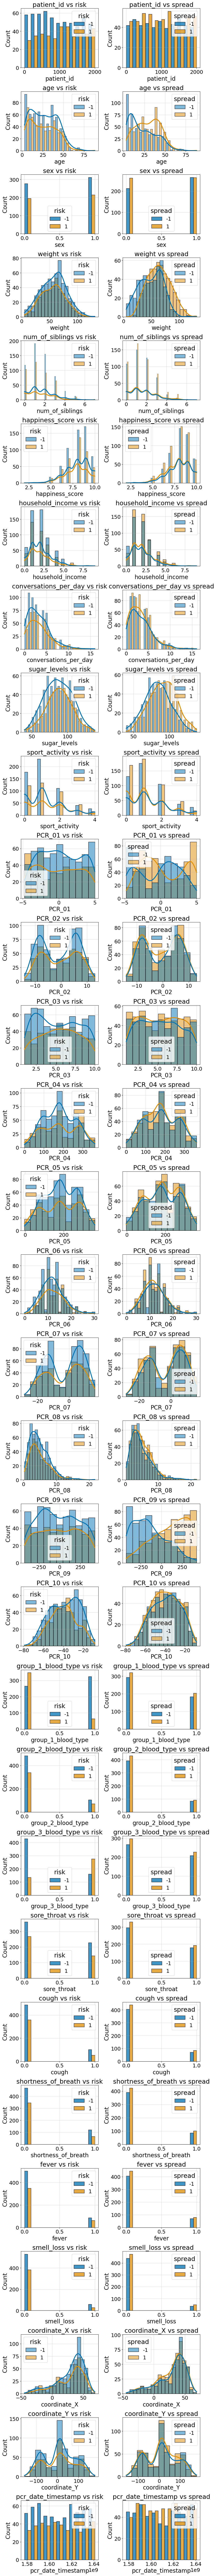

In [ ]:
# Q15
COL_NAME = train.columns.drop(['spread', 'risk'])
COLS, ROWS = (2, len(COL_NAME))

plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
  column = COL_NAME[row] #column name

  for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS,COLS, row * COLS + 1 + j)
 
    isContinuous = "float" in train[column].dtype.name
    isOrdinal = column in ['age','num_of_siblings','happiness_score','household_income','conversations_per_day','sugar_levels','pcr_date', 'sport_activity', 'pcr_date']
    sns.histplot(data=train, x=column, hue=cls, line_kws={"linewidth": 3},
                kde=isContinuous or isOrdinal, multiple="layer" if isContinuous else "dodge", palette='colorblind').set(title=f"{column} vs {cls}")
    plt.grid(alpha=0.5)

plt.tight_layout()

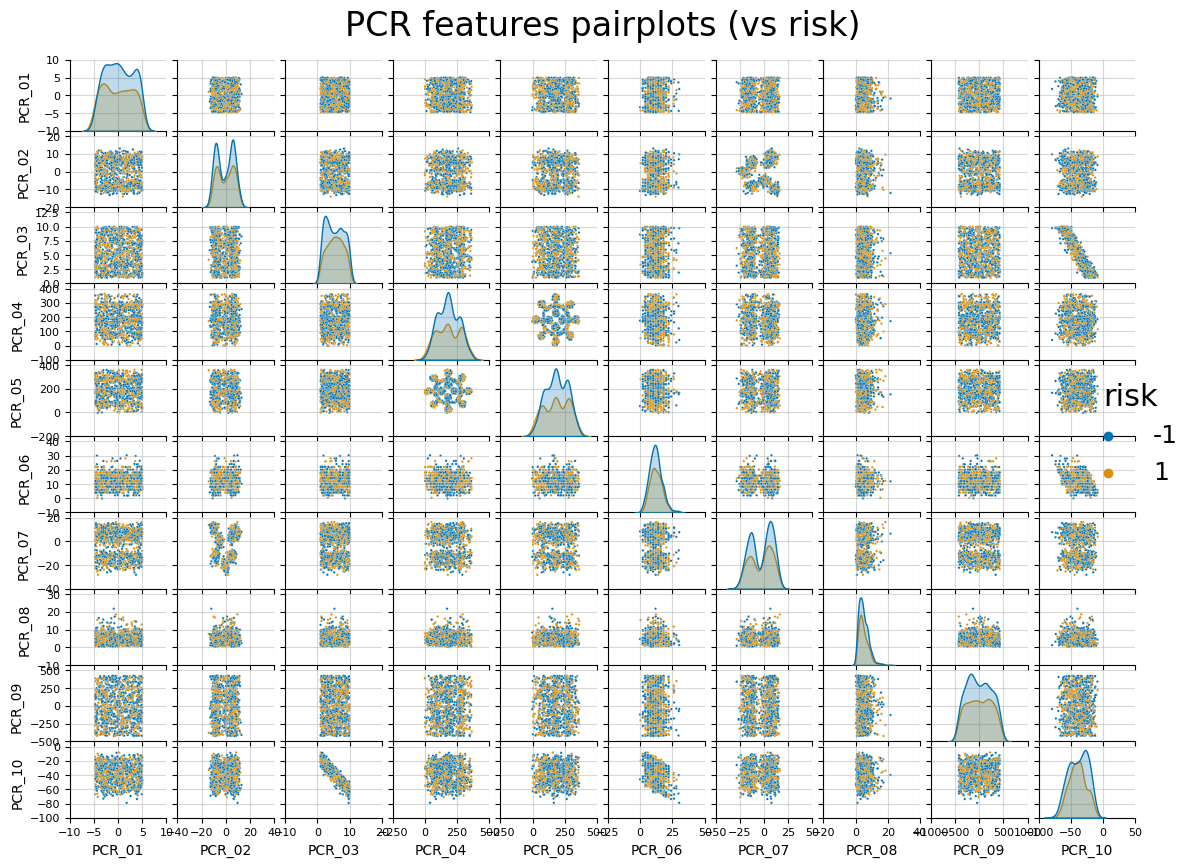

In [ ]:
# Q17
g = sns.pairplot(train[train.filter(like='PCR').columns.tolist() + ["risk"]],
 plot_kws={"s": 3}, hue="risk", palette='colorblind')
g.fig.suptitle("PCR features pairplots (vs risk)", y=1.05)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)
  ax.set_xlabel(ax.get_xlabel(), fontsize=10)
  ax.set_ylabel(ax.get_ylabel(), fontsize=10)
  ax.set_xticks(ax.get_xticks())
  ax.set_yticks(ax.get_yticks())
  ax.tick_params(axis='both', which='major', labelsize=8)

g.fig.set_size_inches(12,8)

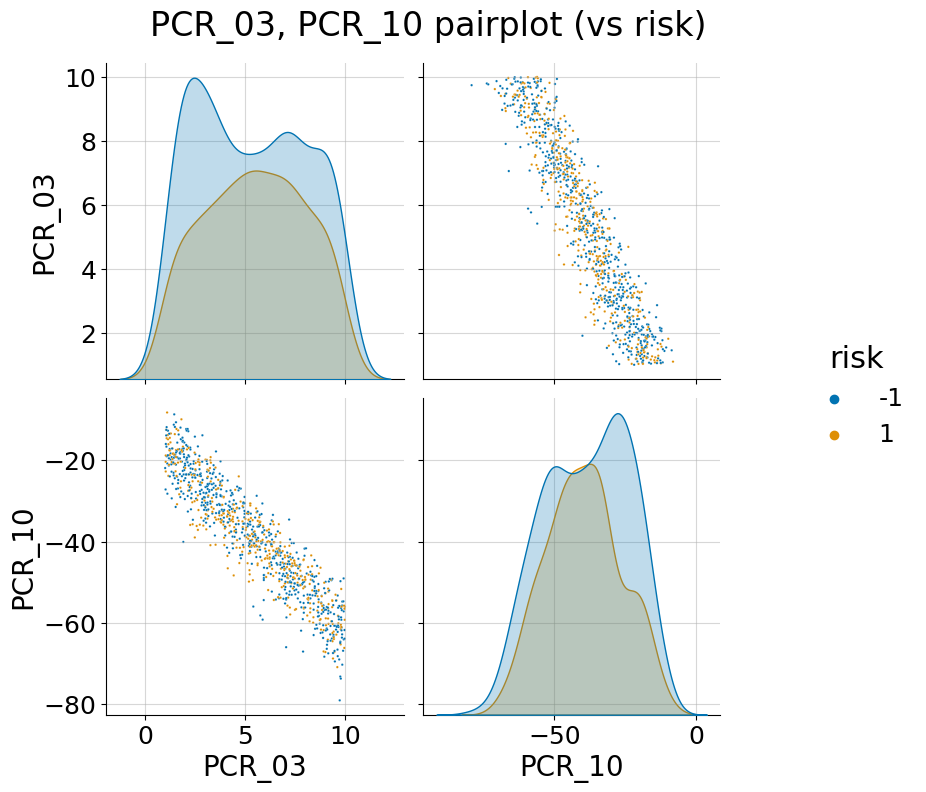

In [ ]:
# Pairplot of PCR_03, PCR_10 vs risk
g = sns.pairplot(train[["PCR_03","PCR_10","risk"]], plot_kws={"s": 3}, hue="risk", palette='colorblind')
g.fig.suptitle("PCR_03, PCR_10 pairplot (vs risk)", y=1.04)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)

  g.fig.set_size_inches(10,8)

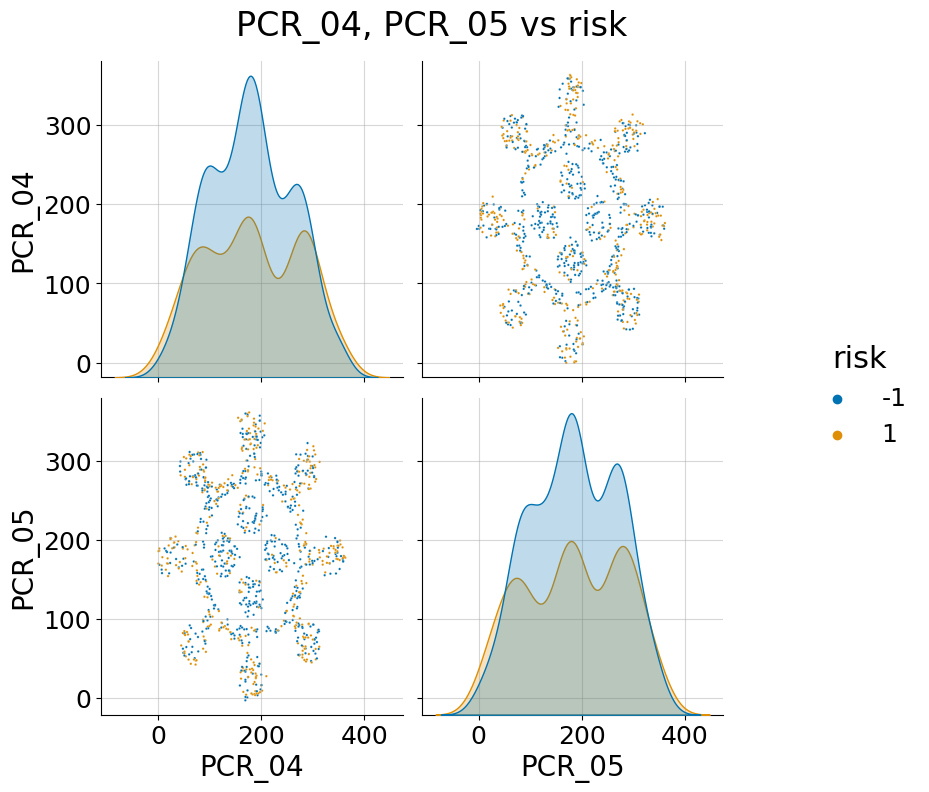

In [ ]:
# Pairplot of PCR_04, PCR_05 vs risk
g = sns.pairplot(train[["PCR_04","PCR_05","risk"]], plot_kws={"s": 3}, hue="risk", palette='colorblind')
g.fig.suptitle("PCR_04, PCR_05 vs risk", y=1.04)

for ax in np.ravel(g.axes):
  ax.grid(alpha=0.5)

  g.fig.set_size_inches(10,8)

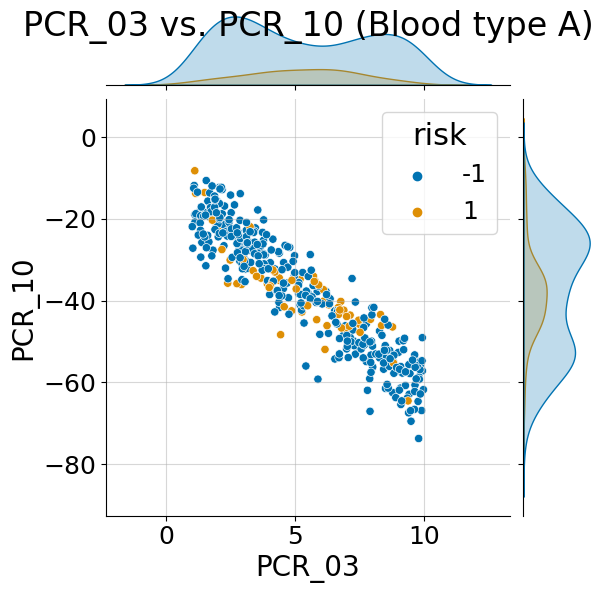

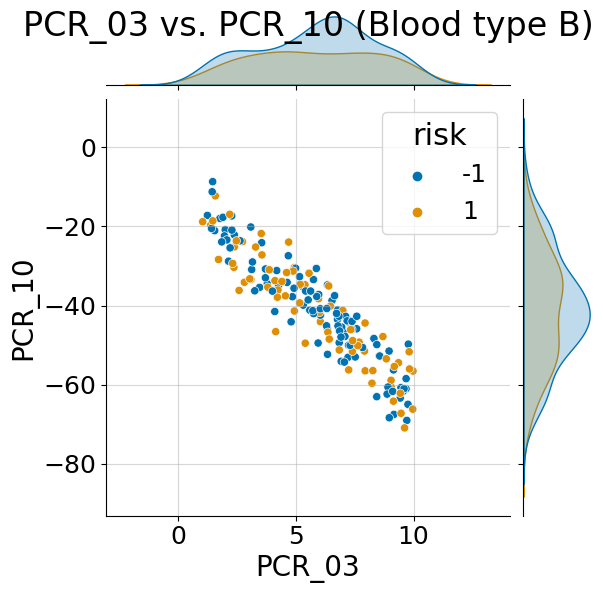

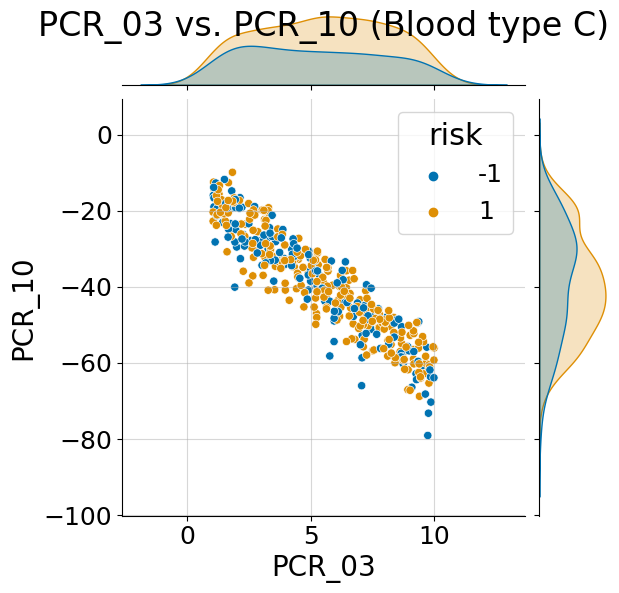

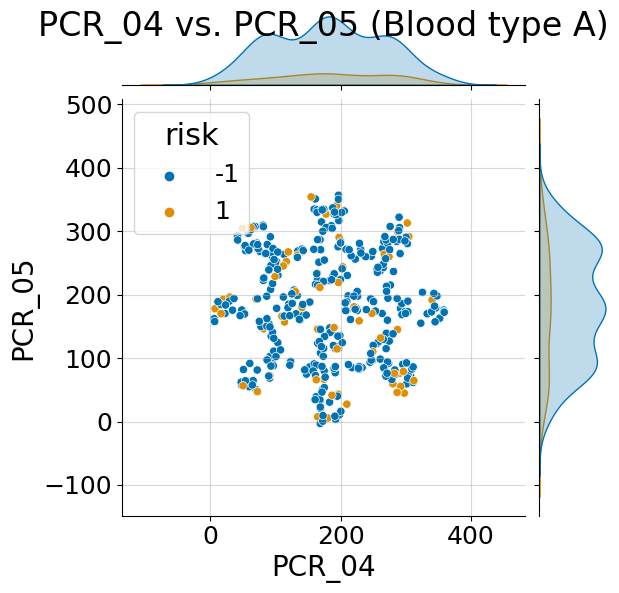

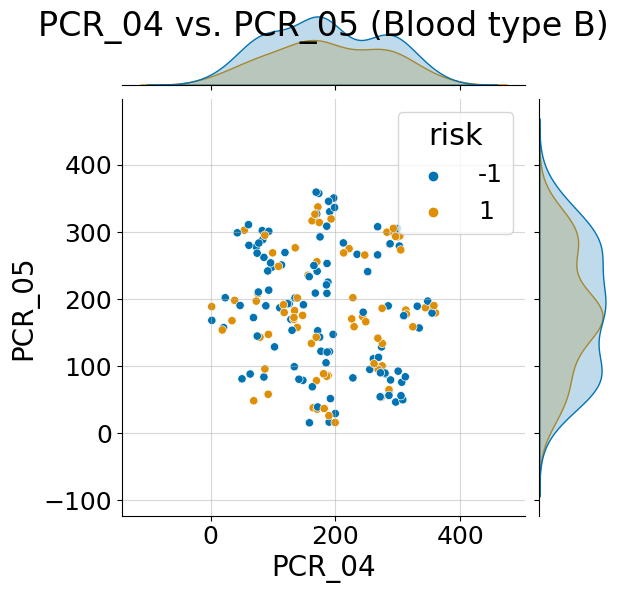

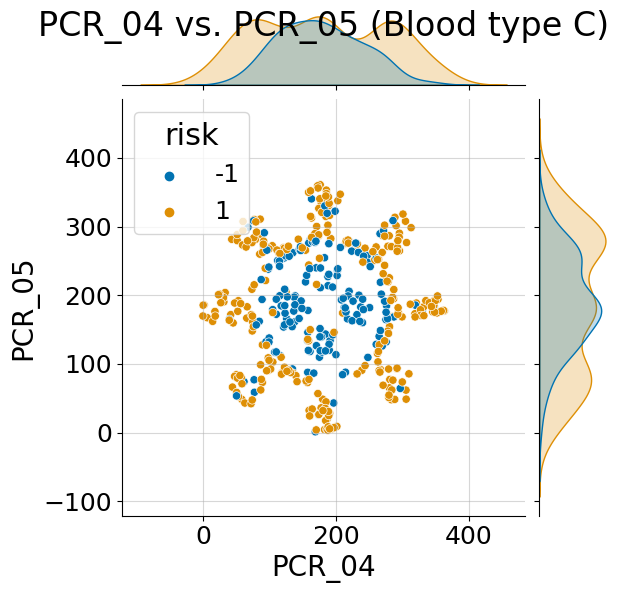

In [ ]:
# Q18
train_blood_group_A = train[(train['group_1_blood_type'] == 1)]
train_blood_group_B = train[(train['group_2_blood_type'] == 1)]
train_blood_group_C = train[(train['group_3_blood_type'] == 1)]

#fig, axes = plt.subplots(1,3, figsize=(14, 6))

# Jointplot for PCR_03,PCR_10 (Blood type A)
g = sns.jointplot(data=train_blood_group_A, x='PCR_03', y='PCR_10', hue='risk', kind="scatter", palette='colorblind')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("PCR_03 vs. PCR_10 (Blood type A)", y=1.05)
g.set_axis_labels("PCR_03", "PCR_10")

# Jointplot for PCR_03,PCR_10 (Blood type B)
g = sns.jointplot(data=train_blood_group_B, x='PCR_03', y='PCR_10', hue='risk', kind="scatter", palette='colorblind')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("PCR_03 vs. PCR_10 (Blood type B)", y=1.05)
g.set_axis_labels("PCR_03", "PCR_10")

# Jointplot for PCR_03,PCR_10 (Blood type C)
g = sns.jointplot(data=train_blood_group_C, x='PCR_03', y='PCR_10', hue='risk', kind="scatter", palette='colorblind')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("PCR_03 vs. PCR_10 (Blood type C)", y=1.05)
g.set_axis_labels("PCR_03", "PCR_10")

# Jointplot for PCR_04,PCR_05 (Blood type A)
g = sns.jointplot(data=train_blood_group_A, x='PCR_04', y='PCR_05', hue='risk', kind="scatter", palette='colorblind')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("PCR_04 vs. PCR_05 (Blood type A)", y=1.05)
g.set_axis_labels("PCR_04", "PCR_05")

# Jointplot for PCR_04,PCR_05 (Blood type B)
g = sns.jointplot(data=train_blood_group_B, x='PCR_04', y='PCR_05', hue='risk', kind="scatter", palette='colorblind')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("PCR_04 vs. PCR_05 (Blood type B)", y=1.05)
g.set_axis_labels("PCR_04", "PCR_05")

# Jointplot for PCR_04,PCR_05 (Blood type C)
g = sns.jointplot(data=train_blood_group_C, x='PCR_04', y='PCR_05', hue='risk', kind="scatter", palette='colorblind')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("PCR_04 vs. PCR_05 (Blood type C)", y=1.05)
g.set_axis_labels("PCR_04", "PCR_05")

In [ ]:
# Pre-Q20
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Creating the scalers
minmax_scaler = MinMaxScaler(feature_range=(-1,1))
standard_scaler = StandardScaler()
train_normalized = train.copy()

# not normalizing patient_id
standard_cols = ['age','weight','num_of_siblings','happiness_score','household_income',
                 'conversations_per_day','sugar_levels','sport_activity','pcr_date_timestamp']

minmax_cols = ['sex','group_1_blood_type','group_2_blood_type','group_3_blood_type','sore_throat','cough',
               'shortness_of_breath','fever','smell_loss','coordinate_X','coordinate_Y'] + train.filter(like='PCR').columns.tolist()

train_normalized[standard_cols] = standard_scaler.fit_transform(train[standard_cols])
train_normalized[minmax_cols] = minmax_scaler.fit_transform(train[minmax_cols])

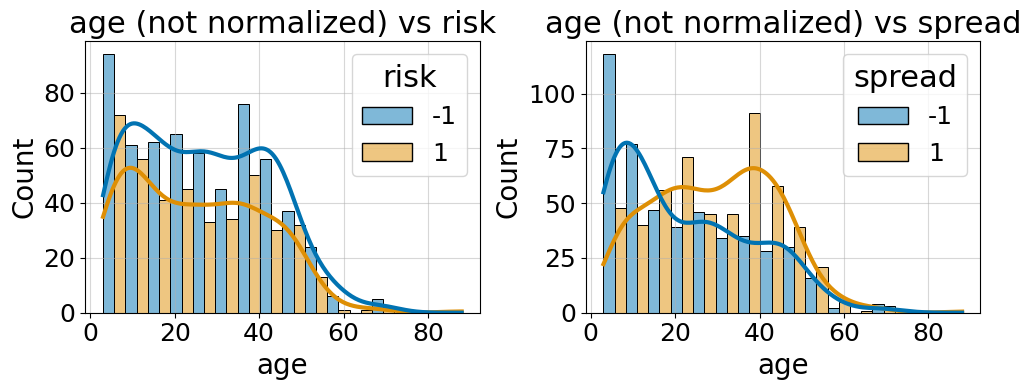

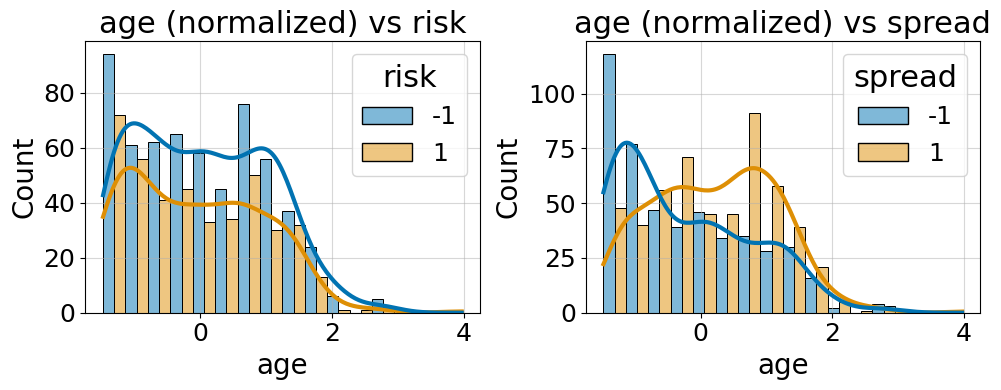

In [ ]:
# Q20
COL_NAME = ['age']
COLS, ROWS = (2, len(COL_NAME))

plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
  column = COL_NAME[row] #column name

  for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS,COLS, row * COLS + 1 + j)
    sns.histplot(data=train, x=column, hue=cls, line_kws={"linewidth": 3},
                kde=True, multiple="dodge", palette="colorblind").set_title(f"age (not normalized) vs {cls}")
    plt.grid(alpha=0.5)

plt.tight_layout()

plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
  column = COL_NAME[row] #column name

  for j, cls in enumerate(["risk", "spread"]):
    plt.subplot(ROWS,COLS, row * COLS + 1 + j)
    sns.histplot(data=train_normalized, x=column, hue=cls, line_kws={"linewidth": 3},
                kde=True, multiple="dodge", palette="colorblind").set_title(f"age (normalized) vs {cls}")
    plt.grid(alpha=0.5)

plt.tight_layout()

In [ ]:
# Q23
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

# Apply Sequntial Feature Selection to find 3 features (that should predict 'spread' label)
knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3)


train_normalized_features = train_normalized.drop(['risk', 'spread'], axis=1).copy()
train_normalized_label = train_normalized[['spread']]
sfs.fit(train_normalized_features, train_normalized_label)
sfs.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

array(['weight', 'PCR_01', 'PCR_09'], dtype=object)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd


def prepare_data(training_data, new_data):
    test = new_data.copy()
    train = training_data.copy()

    # ----- blood_type -> blood types groups -----
    # group_1_blood_type
    train.insert(len(train.columns) - 2, "group_1_blood_type", train['blood_type'].isin(['A+', 'A-']))
    train['group_1_blood_type'] = train['group_1_blood_type'].replace({True: 1, False: 0})
    test.insert(len(test.columns) - 2, "group_1_blood_type", test['blood_type'].isin(['A+', 'A-']))
    test['group_1_blood_type'] = test['group_1_blood_type'].replace({True: 1, False: 0})

    # group_2_blood_type
    train.insert(len(train.columns) - 2, "group_2_blood_type", train['blood_type'].isin(['AB+', 'AB-', 'B+', 'B-']))
    train['group_2_blood_type'] = train['group_2_blood_type'].replace({True: 1, False: 0})
    test.insert(len(test.columns) - 2, "group_2_blood_type", test['blood_type'].isin(['AB+', 'AB-', 'B+', 'B-']))
    test['group_2_blood_type'] = test['group_2_blood_type'].replace({True: 1, False: 0})

    # group_3_blood_type
    train.insert(len(train.columns) - 2, "group_3_blood_type", train['blood_type'].isin(['O+', 'O-']))
    train['group_3_blood_type'] = train['group_3_blood_type'].replace({True: 1, False: 0})
    test.insert(len(test.columns) - 2, "group_3_blood_type", test['blood_type'].isin(['O+', 'O-']))
    test['group_3_blood_type'] = test['group_3_blood_type'].replace({True: 1, False: 0})

    # drop blood_type
    train = train.drop('blood_type', axis=1)
    test = test.drop('blood_type', axis=1)

    # ----- symptoms OHE -----
    train['symptoms'] = train['symptoms'].fillna("")
    test['symptoms'] = test['symptoms'].fillna("")

    # transform symptoms feature into 5 binary features
    train.insert(len(train.columns) - 2, "sore_throat", train['symptoms'].str.contains("sore_throat"))
    train['sore_throat'] = train['sore_throat'].replace({True: 1, False: 0})
    train.insert(len(train.columns) - 2, "cough", train['symptoms'].str.contains("cough"))
    train['cough'] = train['cough'].replace({True: 1, False: 0})
    train.insert(len(train.columns) - 2, "shortness_of_breath", train['symptoms'].str.contains("shortness_of_breath"))
    train['shortness_of_breath'] = train['shortness_of_breath'].replace({True: 1, False: 0})
    train.insert(len(train.columns) - 2, "fever", train['symptoms'].str.contains("fever"))
    train['fever'] = train['fever'].replace({True: 1, False: 0})
    train.insert(len(train.columns) - 2, "smell_loss", train['symptoms'].str.contains("smell_loss"))
    train['smell_loss'] = train['smell_loss'].replace({True: 1, False: 0})
    train = train.drop('symptoms', axis=1)

    # same transformation for test data
    test.insert(len(test.columns) - 2, "sore_throat", test['symptoms'].str.contains("sore_throat"))
    test['sore_throat'] = test['sore_throat'].replace({True: 1, False: 0})
    test.insert(len(test.columns) - 2, "cough", test['symptoms'].str.contains("cough"))
    test['cough'] = test['cough'].replace({True: 1, False: 0})
    test.insert(len(test.columns) - 2, "shortness_of_breath", test['symptoms'].str.contains("shortness_of_breath"))
    test['shortness_of_breath'] = test['shortness_of_breath'].replace({True: 1, False: 0})
    test.insert(len(test.columns) - 2, "fever", test['symptoms'].str.contains("fever"))
    test['fever'] = test['fever'].replace({True: 1, False: 0})
    test.insert(len(test.columns) - 2, "smell_loss", test['symptoms'].str.contains("smell_loss"))
    test['smell_loss'] = test['smell_loss'].replace({True: 1, False: 0})
    test = test.drop('symptoms', axis=1)

    # ----- sex -> 0 for M, 1 for F -----
    train['sex'] = train['sex'].replace({'M': 0, 'F': 1})
    test['sex'] = test['sex'].replace({'M': 0, 'F': 1})

    # ----- current_location -> coordiante_X, coordiante_Y -----
    train['current_location'] = train['current_location'].str.replace(r"[() ']", '')
    train[['coordinate_X', 'coordinate_Y']] = train['current_location'].str.split(',', expand=True)
    train['coordinate_X'] = train['coordinate_X'].apply(float)
    train['coordinate_Y'] = train['coordinate_Y'].apply(float)
    train = train.drop('current_location', axis=1)

    test['current_location'] = test['current_location'].str.replace(r"[() ']", '')
    test[['coordinate_X', 'coordinate_Y']] = test['current_location'].str.split(',', expand=True)
    test['coordinate_X'] = test['coordinate_X'].apply(float)
    test['coordinate_Y'] = test['coordinate_Y'].apply(float)
    test = test.drop('current_location', axis=1)

    # ----- pcr_date -> time since epoch (timestamp) -----
    train['pcr_date_timestamp'] = pd.to_datetime(train['pcr_date'], format="%Y-%m-%d")
    train['pcr_date_timestamp'] = train['pcr_date_timestamp'].apply(pd.Timestamp.timestamp)
    train['pcr_date_timestamp'] = train['pcr_date_timestamp'].astype(int)
    train = train.drop('pcr_date', axis=1)

    test['pcr_date_timestamp'] = pd.to_datetime(test['pcr_date'], format="%Y-%m-%d")
    test['pcr_date_timestamp'] = test['pcr_date_timestamp'].apply(pd.Timestamp.timestamp)
    test['pcr_date_timestamp'] = test['pcr_date_timestamp'].astype(int)
    test = test.drop('pcr_date', axis=1)

    # ----- Scaling -----
    test_normalized = test.copy()

    # not normalizing patient_id
    standard_cols = ['age','weight','num_of_siblings','happiness_score','household_income',
                 'conversations_per_day','sugar_levels','sport_activity','pcr_date_timestamp']

    minmax_cols = ['sex','group_1_blood_type','group_2_blood_type','group_3_blood_type','sore_throat','cough',
               'shortness_of_breath','fever','smell_loss','coordinate_X', 'coordinate_Y'] + train.filter(like='PCR').columns.tolist()

    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    standard_scaler.fit(train[standard_cols])
    test_normalized[standard_cols] = standard_scaler.transform(test[standard_cols])

    minmax_scaler.fit(train[minmax_cols])
    test_normalized[minmax_cols] = minmax_scaler.transform(test[minmax_cols])

    
    return test_normalized


df = pd.read_csv("./virus_data.csv")
train_size = 0.8
test_size = 1 - train_size
train_df, test_df = train_test_split(df, test_size=test_size, train_size=train_size,
                                      random_state=51 + 14, shuffle=True)

# Prepare training set according to itself
train_df_prepared = prepare_data(train_df, train_df)
# Prepare test set according to the raw training set
test_df_prepared = prepare_data(train_df, test_df)

# save CSV
train_df_prepared.to_csv("/content/train_preprocessed.csv")
test_df_prepared.to_csv("/content/test_preprocessed")



<ipython-input-55-26df15431e0b>:68: FutureWarning: The default value of regex will change from True to False in a future version.
  train['current_location'] = train['current_location'].str.replace(r"[() ']", '')
<ipython-input-55-26df15431e0b>:74: FutureWarning: The default value of regex will change from True to False in a future version.
  test['current_location'] = test['current_location'].str.replace(r"[() ']", '')
<ipython-input-55-26df15431e0b>:68: FutureWarning: The default value of regex will change from True to False in a future version.
  train['current_location'] = train['current_location'].str.replace(r"[() ']", '')
<ipython-input-55-26df15431e0b>:74: FutureWarning: The default value of regex will change from True to False in a future version.
  test['current_location'] = test['current_location'].str.replace(r"[() ']", '')
